## Importing Relevant Libraries

In [11]:
from pathlib import Path

In [12]:
import pandas as pd
import numpy as np

In [13]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [14]:
from prophet import Prophet

## Workbook Settings

In [15]:
from IPython.display import display, HTML

def display_scrollable(df, rows=10):
    display(HTML(df.to_html(notebook=True, max_rows=rows, max_cols=None, border=0)))

## Import Relevant Data

In [16]:
data_path = Path("/Users/harsha_gurram/repos/HackUTD-RippleEffect/data")
pipe_df = pd.read_csv(data_path/Path("Bold_744H-10_31-11_07.csv"))

In [17]:
pipe_df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,391.43520,375.0,27.17612
1,10/31/2024 12:14:00 am,402.52365,NaN,NaN
2,10/31/2024 12:30:00 am,380.72775,NaN,26.70198
3,10/31/2024 12:46:00 am,382.73955,NaN,NaN
4,10/31/2024 1:00:00 am,384.86595,375.0,26.70198


## Anamoly Detector

In [18]:
# Initialize the Prophet model
model = Prophet(interval_width=0.99)

# Set time and target variable
pipe_df['ds'] = pipe_df["Time"]
pipe_df['ds'] = pd.to_datetime(pipe_df['ds'])
pipe_df['y'] = pipe_df["Inj Gas Meter Volume Instantaneous"]


# Fit a Prophet model
model = Prophet()
model.fit(pipe_df[['ds', 'y']])

# Make predictions
future = model.make_future_dataframe(periods=0)  # Predict only on existing data
forecast = model.predict(future)

# Merge predictions into the original dataframe
pipe_df['yhat'] = forecast['yhat']
pipe_df['yhat_lower'] = forecast['yhat_lower']
pipe_df['yhat_upper'] = forecast['yhat_upper']

# Detect anomalies above and below standard deviation
pipe_df['anomaly'] = (pipe_df['y'] < pipe_df['yhat_lower']) | (pipe_df['y'] > pipe_df['yhat_upper'])

# Set threshold for anamoly detection 
pipe_df['deviation'] = abs(pipe_df['y'] - pipe_df['yhat'])
threshold = pipe_df['deviation'].quantile(0.99)  # Set a threshold at the 99th percentile
pipe_df['anomaly'] = pipe_df['deviation'] > threshold

/var/folders/ty/8tj8jv412q16qxvqlxqz9jth0000gn/T/ipykernel_94732/1440275855.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pipe_df['ds'] = pd.to_datetime(pipe_df['ds'])
02:51:06 - cmdstanpy - INFO - Chain [1] start processing
02:51:06 - cmdstanpy - INFO - Chain [1] done processing


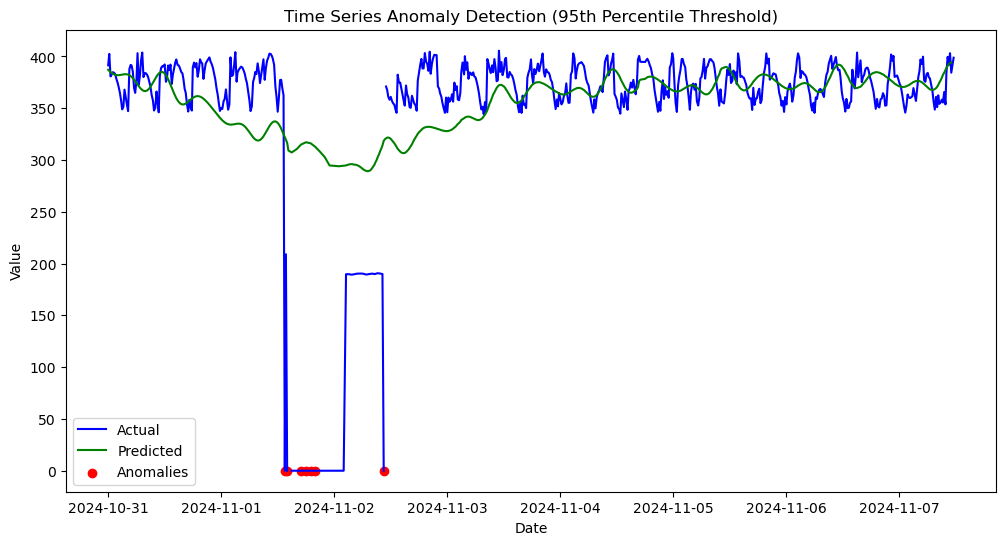

In [19]:
# Plotting the graph
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(pipe_df['ds'], pipe_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(pipe_df['ds'], pipe_df['yhat'], label='Predicted', color='green')

# Highlight anomalies
plt.scatter(pipe_df.loc[pipe_df['anomaly'], 'ds'], 
            pipe_df.loc[pipe_df['anomaly'], 'y'], 
            color='red', label='Anomalies')

# Add labels and legend
plt.title('Time Series Anomaly Detection (95th Percentile Threshold)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

TypeError: can only concatenate str (not "Timedelta") to str

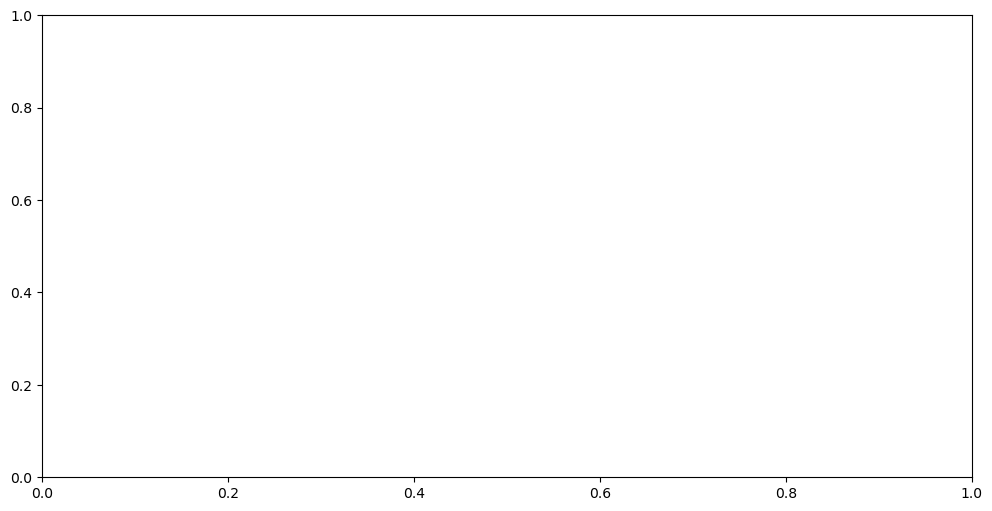

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import time

# Function to simulate live data updates
def simulate_live_data():
    new_time = pipe_df['ds'].iloc[-1] + pd.Timedelta(hours=0.25)
    new_value = 100 + np.sin(len(pipe_df) / 10) * 10 + (50 if len(pipe_df) % 10 == 0 else 0)
    return {'ds': new_time, 'y': new_value}

# Function to periodically plot data
def plot_periodically():
    global pipe_df

    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(figsize=(12, 6))

    while True:
        # Simulate adding a new data point
        new_data = simulate_live_data()
        pipe_df = pd.concat([pipe_df, pd.DataFrame([new_data])], ignore_index=True)

        # Create a new Prophet model and fit it with updated data
        model = Prophet(interval_width=0.99)  # Instantiate a new Prophet model
        model.fit(pipe_df[['ds', 'y']])

        # Predict with the new model
        future = model.make_future_dataframe(periods=0)  # Predict only for historical data
        forecast = model.predict(future)

        # Merge predictions back into the DataFrame
        pipe_df['yhat'] = forecast['yhat']
        pipe_df['deviation'] = abs(pipe_df['y'] - pipe_df['yhat'])
        threshold = pipe_df['deviation'].quantile(0.95)  # Dynamic threshold
        pipe_df['anomaly'] = pipe_df['deviation'] > threshold

        # Clear the previous plot
        ax.clear()

        # Plot the actual values
        ax.plot(pipe_df['ds'], pipe_df['y'], label='Actual', color='blue')

        # Plot the predicted values
        ax.plot(pipe_df['ds'], pipe_df['yhat'], label='Predicted', color='green')

        # Highlight anomalies
        anomalies = pipe_df[pipe_df['anomaly']]
        ax.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies')

        # Customize the plot
        ax.set_title('Real-Time Anomaly Detection')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()

        # Render the plot
        plt.pause(2)  # Pause for 2 seconds to simulate periodic updates

# Start periodic plotting
plot_periodically()